<a href="https://colab.research.google.com/github/arkalim/PyTorch/blob/master/Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch.nn as nn
from torch.hub import load_state_dict_from_url

__all__ = ['ResNet', 'resnet50']

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

def conv3x3(in_planes, out_planes, stride=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,base_width=64, dilation=1):
        super(Bottleneck, self).__init__()
        
        width = int(planes * (base_width / 64.))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride, dilation)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, width_per_group=64):
        super(ResNet, self).__init__()

        self.inplanes = 64
        self.dilation = 1
    
        self.base_width = width_per_group
        
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        previous_dilation = self.dilation
       
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                base_width=self.base_width, dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)

        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

def resnet50(pretrained=False, progress=True, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnet50', Bottleneck, [3, 4, 6, 3], pretrained, progress,
                   **kwargs)

In [0]:
model = resnet50(True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:05<00:00, 17313905.45it/s]


In [0]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

--2019-06-24 04:08:18--  https://turntable.kagiso.io/images/Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png
Resolving turntable.kagiso.io (turntable.kagiso.io)... 104.25.121.109, 104.25.122.109, 2606:4700:20::6819:796d, ...
Connecting to turntable.kagiso.io (turntable.kagiso.io)|104.25.121.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580207 (567K) [image/png]
Saving to: ‘Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png’

Screen_Shot_2019-05 100%[===================>] 566.61K  --.-KB/s    in 0.07s   

2019-06-24 04:08:19 (8.21 MB/s) - ‘Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png’ saved [580207/580207]



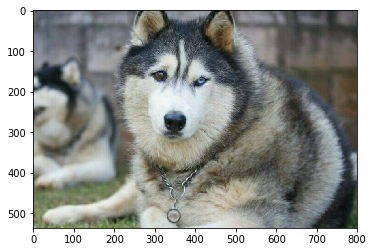

In [0]:
from PIL import Image
import matplotlib.pyplot as plt

!wget https://turntable.kagiso.io/images/Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png

image = Image.open("Screen_Shot_2019-05-20_at_7.49.14_AM.width-800.png")
plt.imshow(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])


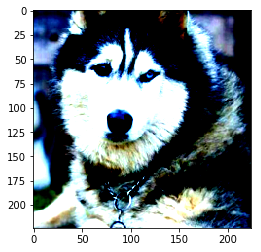

In [0]:
from torchvision import transforms

transform = transforms.Compose([            
     transforms.Resize(256),                    
     transforms.CenterCrop(224),                
     transforms.ToTensor(),                     
     transforms.Normalize(                      
     mean=[0.485, 0.456, 0.406],                
     std=[0.229, 0.224, 0.225]                  
 )])

image = transform(image)

print(image.shape)
plt.imshow(image.numpy().transpose(1,2,0))

# adding batch value of 1
image = image.unsqueeze(dim = 0)
print(image.shape)

In [0]:
!wget https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a/archive/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5.zip
!unzip '238f720ff059c1f82f368259d1ca4ffa5dd8f9f5.zip'    

# this way of reading lines appends the lines in a list
with open('942d3a0ac09ec9e5eb3a-238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt',encoding = "ISO-8859-1") as f:
    classes = [line.strip() for line in f.readlines()]    
    
print(len(classes))

# Print all the Class Names
for class_name in classes:
    print(class_name)

--2019-06-24 04:08:27--  https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a/archive/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5.zip
Resolving gist.github.com (gist.github.com)... 192.30.253.118
Connecting to gist.github.com (gist.github.com)|192.30.253.118|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/gist/942d3a0ac09ec9e5eb3a/zip/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5 [following]
--2019-06-24 04:08:27--  https://codeload.github.com/gist/942d3a0ac09ec9e5eb3a/zip/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5
Resolving codeload.github.com (codeload.github.com)... 192.30.253.120
Connecting to codeload.github.com (codeload.github.com)|192.30.253.120|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘238f720ff059c1f82f368259d1ca4ffa5dd8f9f5.zip’

238f720ff059c1f82f3     [ <=>                ]  13.17K  --.-KB/s    in 0.01s   

2019-06-24 04:08:27 (949 KB/s) - ‘238f720ff059

In [0]:
import torch
import torchvision
from torchvision import models

# set the model to evaluation mode
model.eval()

prediction = model(image)

print(prediction.shape)

# select the only image batch = 0
percentage = torch.nn.functional.softmax(prediction, dim = 1)[0] * 100

# sort the predictions 
values , indices = torch.sort(percentage, descending=True)

# Print top 5 predictions
for index in indices[:5]:
    print(classes[index],percentage[index].item())

torch.Size([1, 1000])
248: 'Eskimo dog, husky', 72.54227447509766
250: 'Siberian husky', 21.664051055908203
269: 'timber wolf, grey wolf, gray wolf, Canis lupus', 2.01191782951355
537: 'dogsled, dog sled, dog sleigh', 1.220119833946228
249: 'malamute, malemute, Alaskan malamute', 0.8515235185623169


In [0]:
import torch.nn as nn
from torch.hub import load_state_dict_from_url

__all__ = ['ResNet', 'resnet50']

model_urls = {
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth'
}

def conv3x3(in_planes, out_planes, stride=1, dilation=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, bias=False)

def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,base_width=64, dilation=1):
        super(Bottleneck, self).__init__()
        
        width = int(planes * (base_width / 64.))
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = conv3x3(width, width, stride, dilation)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layer, num_classes=1000, width_per_group=64):
        super(ResNet, self).__init__()

        self.inplanes = 2048
        self.dilation = 1
    
        self.base_width = width_per_group
        
        self.layer4 = self._make_layer(Bottleneck, 512, layer, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        previous_dilation = self.dilation
       
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(Bottleneck(self.inplanes, planes, stride, downsample,
                            self.base_width, previous_dilation))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes,
                                base_width=self.base_width, dilation=self.dilation))

        return nn.Sequential(*layers)

    def forward(self, x):   
        x = self.layer4(x)
        x = self.avgpool(x)
        return x


def _resnet(arch, block, layers, pretrained, progress, **kwargs):
    model = ResNet(block, layers, **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict, strict = False)
    return model

class OdomNet(nn.Module):
    def __init__(self, pretrained=False, progress=True, **kwargs):
        super(OdomNet, self).__init__()
        
        self.resnet_4=_resnet('resnet50', Bottleneck,3, pretrained, progress, **kwargs)
        self.fc1 = nn.Linear(2048,1024)
        self.fc2 = nn.Linear(1024,3)
        self.fc3 = nn.Linear(1024,4)
        
    def forward(self,x):   
        x = self.resnet_4(x)
        x = self.fc1(x)
        position = self.fc2(x)
        orientation = self.fc3(x)
        return position, orientation

In [0]:
odom = OdomNet(pretrained = False)

In [0]:
odom

OdomNet(
  (resnet_4): ResNet(
    (layer4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(2048, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Bottleneck(
        (conv1): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
     